# Stuff here

- Data Source: https://healthdata.gov/dataset/food-inspections
- License: http://opendefinition.org/licenses/odc-odbl/

Things to try:
    
- Partial dependence plots
- Anova
- Log Reg
- RF
- XGB
- DL
- KNN
- KMeans
- Hierarchical Agglomerative Clustering
- SHAP
- Boruta
- Join with socioeconimc data before or after

**COULD** try KMeans on risk scores to see if data points actually cluster according to these 3 risk groupings

### Set Seed

In [1]:
SEED = 666

### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_curve, auc

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from pylab import figure

### Read Chicago Food Inspections Data
Count records and columns.

In [3]:
food_inspections_df = pd.read_csv('data/Food_Inspections.gz', compression='gzip')

In [4]:
food_inspections_df.shape

(195116, 17)

### Rename Columns

In [5]:
food_inspections_df.columns.tolist()

['Inspection ID',
 'DBA Name',
 'AKA Name',
 'License #',
 'Facility Type',
 'Risk',
 'Address',
 'City',
 'State',
 'Zip',
 'Inspection Date',
 'Inspection Type',
 'Results',
 'Violations',
 'Latitude',
 'Longitude',
 'Location']

In [6]:
columns = ['inspection_id', 'dba_name', 'aka_name', 'license_number', 'facility_type',
           'risk', 'address', 'city', 'state', 'zip', 'inspection_date', 'inspection_type',
           'result', 'violation', 'latitude', 'longitude', 'location']

In [7]:
food_inspections_df.columns = columns

### Normalize Casing of Chicago
Accept only proper spellings of the word Chicago with mixed casing accepted

In [8]:
food_inspections_df['city'] = food_inspections_df['city'].apply(lambda x: 'CHICAGO'
                                                                if str(x).upper() == 'CHICAGO'
                                                                else x)

### Filter for Facilities in Chicago Illinois

In [9]:
loc_condition = (food_inspections_df['city'] == 'CHICAGO') & (food_inspections_df['state'] == 'IL')

### Drop Redundant Information
- Only Chicago is considered
- Only Illinois is considered
- Location is encoded as separate latitute and longitude columns

In [10]:
food_inspections_df = food_inspections_df[loc_condition].drop(['city', 'state', 'location'], 1)

In [11]:
food_inspections_df.shape

(194684, 14)

### Create Codes Corresponding to Each Violation Type by Parsing Violation Text

In [12]:
def create_violation_code(violation_text):
    
    if violation_text != violation_text:
        return -1
    else:
        return int(violation_text.split('.')[0])

In [13]:
food_inspections_df['violation_code'] = food_inspections_df['violation'].apply(create_violation_code)

### Create Attribute Dataframes with the Unique Inspection ID for Lookups Following Quantitative Analysis
- Names
- Licenses
- Locations
- Violations
- Dates

In [14]:
names = ['inspection_id', 'dba_name', 'aka_name']
names_df = food_inspections_df[names]

In [15]:
licenses = ['inspection_id', 'license_number']
licenses_df = food_inspections_df[licenses]

In [16]:
locations = ['inspection_id', 'address', 'latitude', 'longitude']
locations_df = food_inspections_df[locations]

In [17]:
violations = ['inspection_id', 'violation', 'violation_code']
violations_df = food_inspections_df[violations]

In [18]:
dates = ['inspection_id', 'inspection_date']
dates_df = food_inspections_df[dates]

### Drop Features Not Used in Statistical Analysis
Features such as:

- `DBA Name`
- `AKA Name`
- `License #`
- `Address`
- `Violations`
- `Inspection Date`

May be examined following statistical analysis by joining on `Inspection ID`.  **Note:** future iterations of this work may wish to consider:

- Text from the the facility name
- Street level information from the facility address
- Prior inspections of the same facility by performing a temporal analysis of the data using `Inspection Date`

In [19]:
not_considered = ['dba_name', 'aka_name', 'license_number', 'address', 'violation', 'inspection_date']
food_inspections_df = food_inspections_df.drop(not_considered, 1)

### Create Dataframes of Count and Prevalence for Categorical Features
- Facility types
- Violation codes
- Zip codes
- Inspection types

In [20]:
facilities = food_inspections_df['facility_type'].value_counts()
facilities_df = pd.DataFrame({'facility_type':facilities.index, 'count':facilities.values})
facilities_df['prevalence'] = facilities_df['count'] / food_inspections_df.shape[0]

In [21]:
facilities_df.nlargest(10, 'count')

,facility_type,count,prevalence
0,Restaurant,129938,0.667430
1,Grocery Store,24829,0.127535
2,School,12062,0.061957
3,Children's Services Facility,3031,0.015569
4,Bakery,2837,0.014572
5,Daycare (2 - 6 Years),2682,0.013776
6,Daycare Above and Under 2 Years,2355,0.012097
7,Long Term Care,1340,0.006883
8,Catering,1190,0.006112
9,Liquor,847,0.004351


In [22]:
facilities_df.nsmallest(10, 'count')

,facility_type,count,prevalence
401,HERBALIFE STORE,1,0.000005
402,GROCERY/LIQUOR,1,0.000005
403,drug treatment facility,1,0.000005
404,BOOK STORE,1,0.000005
405,CAT/LIQUOR,1,0.000005
406,PREPACAKAGED FOODS,1,0.000005
407,NON-FOR PROFIT BASEMENT KIT,1,0.000005
408,FARMER'S MARKET,1,0.000005
409,GAS STATION/GROCERY,1,0.000005
410,NAIL SHOP,1,0.000005


In [23]:
violations = food_inspections_df['violation_code'].value_counts()
violations_df = pd.DataFrame({'violation_code':violations.index, 'count':violations.values})
violations_df['prevalence'] = violations_df['count'] / food_inspections_df.shape[0]

In [24]:
violations_df.nlargest(10, 'count')

,violation_code,count,prevalence
0,-1,51543,0.264752
1,32,25408,0.130509
2,33,17449,0.089627
3,3,13609,0.069903
4,34,10576,0.054324
5,18,9989,0.051309
6,30,9441,0.048494
7,2,7166,0.036808
8,35,5631,0.028924
9,21,4582,0.023536


In [25]:
violations_df.nsmallest(10, 'count')

,violation_code,count,prevalence
61,61,1,0.000005
62,63,1,0.000005
60,70,6,0.000031
58,15,11,0.000057
59,60,11,0.000057
57,59,13,0.000067
56,50,17,0.000087
55,20,18,0.000092
54,52,19,0.000098
53,54,25,0.000128


In [26]:
zips = food_inspections_df['zip'].value_counts()
zips_df = pd.DataFrame({'zip':zips.index, 'count':zips.values})
zips_df['prevalence'] = zips_df['count'] / food_inspections_df.shape[0]

In [27]:
zips_df.nlargest(10, 'count')

,zip,count,prevalence
0,60614.0,7284,0.037414
1,60647.0,7088,0.036408
2,60657.0,6824,0.035052
3,60622.0,6108,0.031374
4,60611.0,6094,0.031302
5,60608.0,5925,0.030434
6,60618.0,5923,0.030424
7,60625.0,5387,0.027670
8,60639.0,5208,0.026751
9,60607.0,5145,0.026427


In [28]:
zips_df.nsmallest(10, 'count')

,zip,count,prevalence
59,60627.0,2,0.000010
60,60805.0,2,0.000010
58,60827.0,134,0.000688
57,60633.0,341,0.001752
56,60656.0,814,0.004181
55,60655.0,816,0.004191
54,60707.0,1125,0.005779
53,60604.0,1290,0.006626
52,60602.0,1409,0.007237
51,60646.0,1411,0.007248


In [29]:
inspections = food_inspections_df['inspection_type'].value_counts()
inspections_df = pd.DataFrame({'inspection_type':inspections.index, 'count':inspections.values})
inspections_df['prevalence'] = inspections_df['count'] / food_inspections_df.shape[0]

In [30]:
inspections_df.nlargest(10, 'count')

,inspection_type,count,prevalence
0,Canvass,102944,0.528775
1,License,25614,0.131567
2,Canvass Re-Inspection,20457,0.105078
3,Complaint,18093,0.092935
4,License Re-Inspection,8899,0.045710
5,Complaint Re-Inspection,7499,0.038519
6,Short Form Complaint,6717,0.034502
7,Suspected Food Poisoning,850,0.004366
8,Consultation,669,0.003436
9,License-Task Force,604,0.003102


In [31]:
inspections_df.nsmallest(10, 'count')

,inspection_type,count,prevalence
41,OWNER SUSPENDED OPERATION/LICENSE,1,0.000005
42,Summer Feeding,1,0.000005
43,KITCHEN CLOSED FOR RENOVATION,1,0.000005
44,LICENSE CANCELED BY OWNER,1,0.000005
45,DAY CARE LICENSE RENEWAL,1,0.000005
46,expansion,1,0.000005
47,Kids Cafe',1,0.000005
48,LIQUOR CATERING,1,0.000005
49,KIDS CAFE,1,0.000005
50,ADDENDUM,1,0.000005


In [32]:
results = food_inspections_df['result'].value_counts()
results_df = pd.DataFrame({'result':results.index, 'count':results.values})
results_df['prevalence'] = results_df['count'] / food_inspections_df.shape[0]

In [33]:
results_df.nlargest(10, 'count')

,result,count,prevalence
0,Pass,105369,0.541231
1,Fail,37658,0.193431
2,Pass w/ Conditions,26795,0.137633
3,Out of Business,16757,0.086073
4,No Entry,6198,0.031836
5,Not Ready,1843,0.009467
6,Business Not Located,64,0.000329


### Drop Violation Code for Now
We can join back using the Inspection ID to learn about types of violations, but we don't want to use any information about the violation itself to predict if a food inspection will pass or fail.

In [34]:
food_inspections_df = food_inspections_df.drop('violation_code', 1)

### Create Risk Group Feature
If the feature cannot be found in the middle of the text string as a value 1-3, return -1.

In [35]:
def create_risk_groups(risk_text):
    
    try: 
        risk = int(risk_text.split(' ')[1])
        return risk
    except:
        return -1

In [36]:
food_inspections_df['risk'] = food_inspections_df['risk'].apply(create_risk_groups)

### Format Result
- Encode Pass and Pass w/ Conditions as 0
- Encode Fail as 1
- Encode all others as -1 and filter out

In [37]:
def format_results(result):
    
    if result == 'Pass':
        return 0
    elif result == 'Pass w/ Conditions':
        return 0
    elif result == 'Fail':
        return 1
    else:
        return -1

In [38]:
food_inspections_df['result'] = food_inspections_df['result'].apply(format_results)
food_inspections_df = food_inspections_df[food_inspections_df['result'] != -1]

In [39]:
food_inspections_df.shape

(169822, 8)

### Filter for Categorical Features that Pass some Prevalence Threshold
This way we only consider fairly common attributes of historical food establishments and inspections so that our analysis will generalize to new establishments and inspections.

In [40]:
categorical_features = ['facility_type', 'zip', 'inspection_type']

In [41]:
def prev_filter(df, feature, prevalence='prevalence', prevalence_threshold=0.001):
    
    return df[df[prevalence] > prevalence_threshold][feature].tolist()

In [42]:
feature_dict = dict(zip(categorical_features, [prev_filter(facilities_df, 'facility_type'),
                                               prev_filter(zips_df, 'zip'),
                                               prev_filter(inspections_df, 'inspection_type')]))

### Encode Rare Features with the 'DROP' String, to be Removed Later
Note that by mapping all rare features to the 'DROP' attribute, we avoid having to one-hot-encode all rare features and then drop them after the fact.  That would create an unnecessarily large feature matrix.  Instead we one-hot encode features passing the prevalence threshold and then drop all rare features that were tagged with the 'DROP' string.

In [43]:
for feature in categorical_features:
    food_inspections_df[feature] = food_inspections_df[feature].apply(lambda x: 
                                                                      x if x in feature_dict[feature]
                                                                      else 'DROP')

In [44]:
feature_df = pd.get_dummies(food_inspections_df,
                            prefix=['{}_'.format(feature) for feature in categorical_features],
                            columns=categorical_features)

In [45]:
feature_df = feature_df[[col for col in feature_df.columns if 'DROP' not in col]]

In [46]:
feature_df.shape

(169822, 96)

### Drop Features with:
- Risk level not recorded as 1, 2, or 3
- Result not recorded as Pass, Pass w/ Conditions, or Fail
- NA values (Some latitudes and longitudes were NA)

In [47]:
feature_df = feature_df[feature_df['risk'] != -1]
feature_df = feature_df[feature_df['result'] != -1]
feature_df = feature_df.dropna()

In [48]:
feature_df.shape

(169305, 96)

### Split Dataset into Train and Test

In [49]:
train_df, test_df = train_test_split(feature_df,
                                     test_size=0.20,
                                     shuffle=True,
                                     random_state=SEED)

In [50]:
train_df.shape

(135444, 96)

In [51]:
test_df.shape

(33861, 96)

In [52]:
X_train = train_df.drop(['inspection_id', 'result'], 1)
X_test = test_df.drop(['inspection_id', 'result'], 1)
y_train = train_df['result']
y_test = test_df['result']

In [53]:
def plot_pca(X):
    '''
    Plots variance explained per number of principle components.
    '''
    
    pca_full = PCA(n_components=min(X.shape[0], X.shape[1]))
    pca_full.fit(X)

    plt.clf()
    plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Variance Explained by Principal Components')
    plt.show()

In [54]:
def plot_kmeans(X, upper=20):
    '''
    Plots value of K Means objective function per number of clusters.
    '''
    
    distorsions = []
    for k in range(1, upper):
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=SEED)
        kmeans.fit(X)
        distorsions.append(kmeans.inertia_)

    plt.plot(range(1, upper), distorsions)
    plt.title('K Means++ Elbow Curve')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Value of Objective Function')
    plt.show()

In [55]:
def scatter_points(X, ax, colors, labels, dependent_vars, mark_dependent_vars):
    '''
    Logs datapoint positions and cluster assignments in 3D space.
    '''

    for i in range(len(X)):
        marker = None
        if mark_dependent_vars:
            if dependent_vars[i] == 1:
                marker = '+'
            elif dependent_vars[i] == 2:
                marker = 'o'
            elif dependent_vars[i] == 3:
                marker = '-'
            else:
                marker = None

        ax.scatter(X[i][0], X[i][1], X[i][2], c=colors[labels[i]], marker=marker, s=80)

In [56]:
def plot_clusters(X, num_clusters, dependent_vars, mark_dependent_vars):
    '''
    Plots datapoints and cluster assignments in 3D space.
    '''

    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=SEED)
    kmeans.fit(X)

    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_

    print('Centroids: \n')
    print(centroids)
    print()

    color_options = ['g', 'r', 'b', 'y', 'c', 'm', 'b', 'w']
    colors = color_options[0:num_clusters]

    c = Counter(labels)
    fig = figure(figsize=(12, 12))
    ax = fig.gca(projection='3d')

    scatter_points(X, ax, colors, labels, dependent_vars, mark_dependent_vars)

    for cluster in range(0, num_clusters):
        print('Cluster {} contains {} samples'.format(cluster, c[cluster]))
        
    print()
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],\
               marker='x', s=100, linewidths=5, zorder=100, c=colors)

    plt.title('Projected K Means++ Clusters', fontsize=20)
    plt.show()
    
    return kmeans

In [57]:
def plot_3D_clusters(plot_df, results, color_map):
    """
    Given 1) a pandas dataframe of sample sky survey image points
    and the predictions from the GMM model 2) the results
    dataframe from the GMM model containing the cluster means,
    and 3) a color map defining the way to color each numbered 
    cluster, generate a 3D plot of the cluster means and
    sky survey image points in the sample, colored according
    to how each data point was clustered.
    """
    
    fig = plt.figure(1, figsize=(8, 8))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=40, azim=134)

    scatter = ax.scatter(plot_df['X'], plot_df['Y'], plot_df['Z'],
                         c=plot_df['color'],
                         edgecolor='k',
                         alpha=0.3)

    ax.set_xlabel('X Dimension', size=16)
    ax.set_ylabel('Y Dimension', size=16)
    ax.set_zlabel('Z Dimension', size=16)
    ax.set_title('GMM Clusters of Sky Survey Images', size=20)

    for mean, color in zip(np.array(results['mean'].tolist()), color_map.values()):
        ax.scatter(mean[0], mean[1], mean[2],\
                   marker = "o",
                   s=100,
                   linewidths=10,
                   alpha=0.9,
                   c=color)

    patches = [mpatches.Patch(color=item[1], label='Cluster {}'.format(item[0]))
               for item in color_map.items()]
    ax.legend(handles=patches)
    fig.show()

### See if We Can Reproduce Risk clusters

In [58]:
minmax_scaler = MinMaxScaler(feature_range=(0, 1))
col_subset_scaler = ColumnTransformer(remainder='passthrough', # passthrough features not listed
                                      transformers=[('mm', minmax_scaler, ['latitude', 'longitude'])])

In [59]:
Xt = col_subset_scaler.fit_transform(X_train.drop('risk', 1))

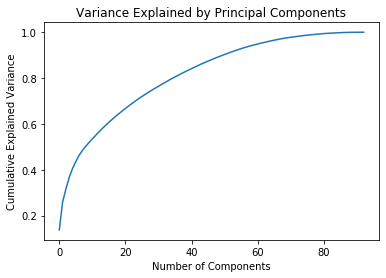

In [60]:
plot_pca(Xt)

In [61]:
pca = PCA(n_components=3)
X_PCA = pca.fit_transform(Xt)

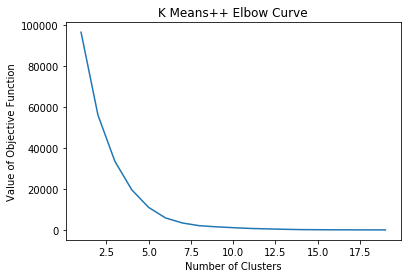

In [62]:
plot_kmeans(X_PCA)

Centroids: 

[[ 0.35712193  0.65788338  0.02280991]
 [ 0.3023369  -0.55404925  0.03299703]
 [-0.65737967 -0.06938306 -0.05605136]]

Cluster 0 contains 43855 samples
Cluster 1 contains 46417 samples
Cluster 2 contains 45172 samples



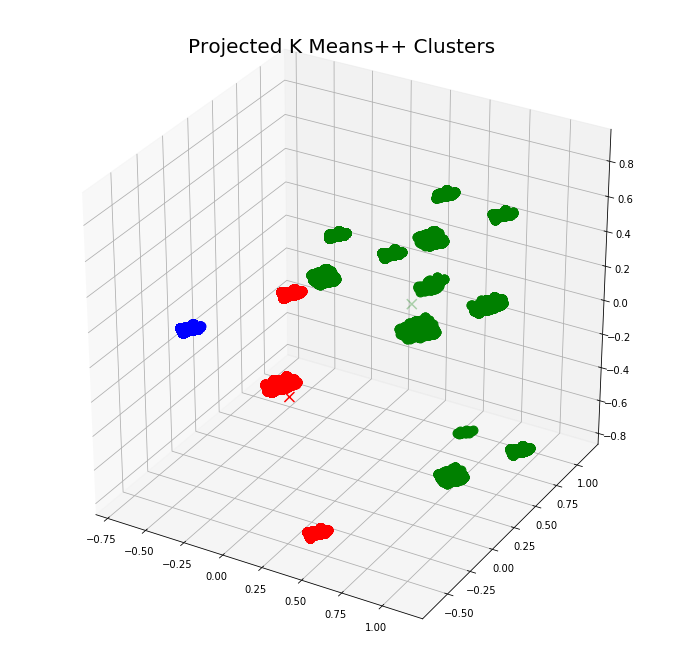

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=666, tol=0.0001, verbose=0)

In [63]:
plot_clusters(X_PCA, 3, X_train['risk'].values, mark_dependent_vars=False)

### Build a Classifier 

### View Prevalence to Select Classification Metric of Interest

In [64]:
round(np.mean(y_train), 3)

0.222

In [65]:
minmax_scaler = MinMaxScaler(feature_range=(0, 1))
col_subset_scaler = ColumnTransformer(remainder='passthrough', # passthrough features not listed
                                      transformers=[('mm', minmax_scaler, ['risk', 'latitude', 'longitude'])])

In [66]:
clf = LogisticRegression(penalty='l1',
                         solver='liblinear',
                         fit_intercept=True,
                         max_iter=1000)

In [67]:
pipeline = Pipeline([('scaler', col_subset_scaler),
                     ('clf', clf)])

In [68]:
cv = StratifiedKFold(n_splits=3,
                     shuffle=True,
                     random_state=SEED)

In [69]:
param_grid = {'clf__C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

In [70]:
gs = GridSearchCV(estimator=pipeline,
                  cv=cv,
                  param_grid=param_grid,
                  scoring='average_precision',
                  n_jobs=-2,
                  refit=True,
                  verbose=2)

In [71]:
%%time
gs = gs.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  15 out of  18 | elapsed:   24.0s remaining:    4.8s
[Parallel(n_jobs=-2)]: Done  18 out of  18 | elapsed:   31.1s finished


CPU times: user 9.68 s, sys: 442 ms, total: 10.1 s
Wall time: 40.2 s


In [72]:
scores = gs.cv_results_['mean_test_score']
best_score = round(gs.best_score_, 5)
best_params = gs.best_params_
best_clf = gs.best_estimator_
print("Best score: {}".format(best_score))
print("Best parameters: {}".format(best_params))

Best score: 0.37506
Best parameters: {'clf__C': 1}


### Evaluate Classifier on Test Set

In [73]:
y_prob = best_clf.predict_proba(X_test)[:, 1]

In [74]:
def plot_hist(labels, scores, bins=30):
    """
    Plot two histograms: one of
    the actual binary labels
    and one of the model scores
    """
    
    plt.clf()
    plt.figure(figsize=(10, 10))
    
    plt.subplot(221)
    sns.distplot(labels, kde=False, color='orange')
    plt.xlabel('Actual Label', fontsize=12)
    plt.xticks([0, 1])
    plt.subplot(222)
    sns.distplot(scores, bins=bins, kde=False, color='orange')
    plt.xlabel('Scores', fontsize=12)
    plt.xticks([0, 0.25, 0.5, 0.75, 1])
    plt.subplots_adjust(hspace=0.5)
    plt.subplot(223)
    sns.distplot(scores[labels == 0], bins=bins, kde=False, color='orange')
    plt.xlabel('Actual Label = 0', fontsize=12)
    plt.subplot(224)
    sns.distplot(scores[labels == 1], bins=bins, kde=False, color='orange')
    plt.xlabel('Actual Label = 1', fontsize=12)
    plt.suptitle('Histograms of Model Scores by Actual Label', fontsize=16)
    plt.show()

<Figure size 432x288 with 0 Axes>

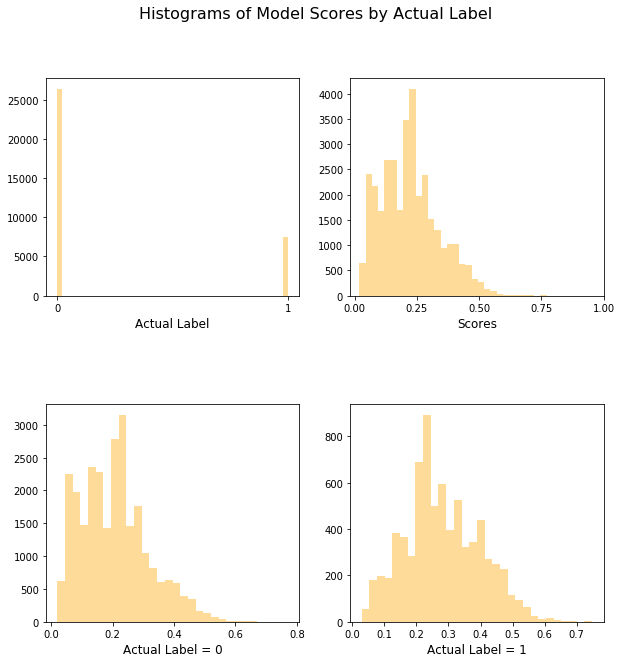

In [75]:
plot_hist(y_test, y_prob)

In [76]:
def plot_roc(labels, scores):
    """
    Plots the true positive rate vs. the false positive rate
    """

    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.clf()
    plt.plot(fpr, tpr, color='darkgreen', lw=2,
             label='AUC = %0.3f' % (roc_auc))
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.suptitle('Receiver Operating Characteristic', fontsize=16)
    plt.legend(loc="lower right")

    plt.show()

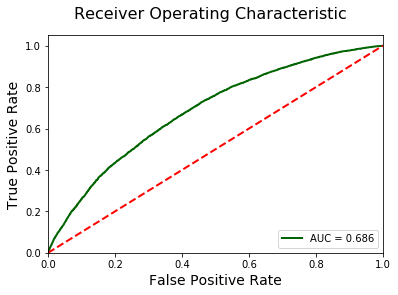

In [77]:
plot_roc(y_test, y_prob)

In [78]:
def plot_pr_by_threshold(labels, scores):
    """
    Plots model precision and recall
    by threshold, using matplotlib and seaborn
    allowing a user to visualize model performance
    at various thresholds
    """

    precision, recall, thresholds = precision_recall_curve(labels, scores)
    thresholds = np.append(thresholds, 1)

    plt.clf()
    plt.plot(thresholds, precision, color=sns.color_palette()[0])
    plt.plot(thresholds, recall, color=sns.color_palette()[1])

    leg = plt.legend(('Precision', 'Recall'), frameon=True)
    leg.get_frame().set_edgecolor('k')

    plt.xlabel('Threshold', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.suptitle('Precision and Recall by Model Threshold', fontsize=16)

    plt.show()

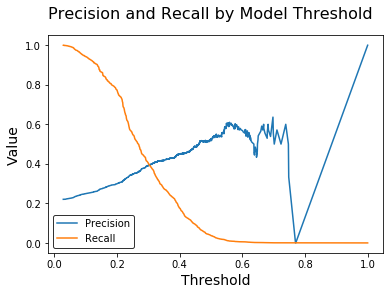

In [79]:
plot_pr_by_threshold(y_test, y_prob)

In [80]:
def plot_coef_effect_size(clf, features, zero_threshold=0.01):
    """
    Plots the change in the odds of the response per unit change 
    in the predictor for each feature given a logistic
    regression model and array of features.  Uses the zero 
    threshold to only plot features with coefficient value
    greater than the threshold.
    
    """

    features_and_intercept = np.concatenate((features, ['intercept']), 0)
    coefficients = np.concatenate((clf.coef_[0], clf.intercept_), 0)

    coefficients[np.abs(coefficients) < zero_threshold] = 0
    coefficients = np.exp(coefficients)

    idx1 = coefficients.argsort()
    all_effects = coefficients[idx1]

    idx2 = np.nonzero(all_effects-1.0)
    effects = all_effects[idx2]
    labels = features_and_intercept[idx1][idx2]
    
    plt.clf()
    plt.figure(figsize=(12, 12))

    plt.title('Exponentiated Logistic Regression Coefficients')
    plt.barh(range(len(effects)), effects, color='navy', align='center')
    plt.axvline(x=1, color='red', linestyle='--')
    plt.yticks(range(len(effects)), labels)
    plt.xlabel('Change in Odds of Response per Unit Change in Predictor')
    plt.ylabel('Feature')

    plt.show()

<Figure size 432x288 with 0 Axes>

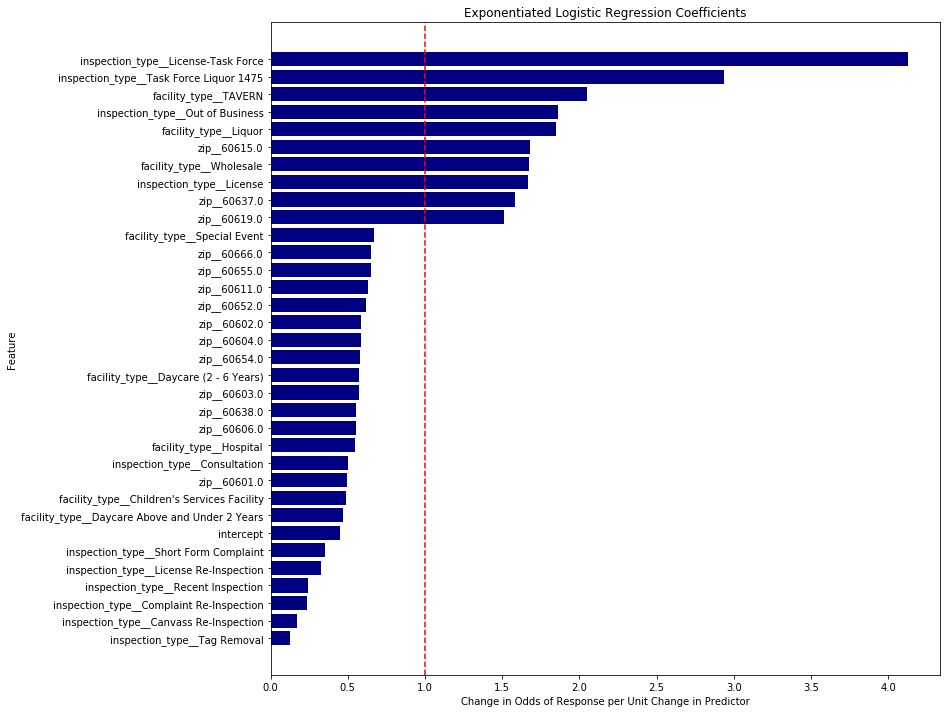

In [81]:
plot_coef_effect_size(best_clf['clf'], X_train.columns, zero_threshold=0.4)